# LSTM model for forecasting temperature

Import necessary libs

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

### Read file

In [72]:
temperature_data = pd.read_csv("temperature_data/VIC/vic_temperature_data.csv")

In [73]:
temperature_data

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586471,IDCJAC0010,90186.0,2020.0,8,2.0,15.0,1.0,N,IDCJAC0011,5.8,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-02
586472,IDCJAC0010,90186.0,2020.0,8,3.0,12.9,1.0,N,IDCJAC0011,5.9,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-03
586473,IDCJAC0010,90186.0,2020.0,8,4.0,10.6,1.0,N,IDCJAC0011,2.5,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-04
586474,IDCJAC0010,90186.0,2020.0,8,5.0,11.0,1.0,N,IDCJAC0011,5.6,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-05


### Find out the number of LGAs

In [74]:
temperature_data['localgovernmentarea'].unique()

array(['Mildura Shire', 'Swan Hill', 'Horsham',
       'Naracoorte and Lucindale', 'Northern Grampians', 'Campaspe',
       'Central Goldfields', 'Greater Shepparton', 'Greater Bendigo',
       'Moira', 'Corowa Shire', 'Murrindindi', 'Alpine', 'Wangaratta',
       'Greater Hume Shire', 'Benalla', 'Mansfield', 'Bega Valley',
       'East Gippsland', 'Bombala', 'Wellington', 'Latrobe',
       'Moonee Valley', 'Banyule', nan, 'Knox', 'Bass Coast', 'Brimbank',
       'Mornington Peninsula', 'Casey', 'Yarra Ranges', 'Wyndham',
       'Greater Geelong', 'Mount Alexander', 'Whittlesea',
       'Ballarat North', 'Ararat', 'Colac-Otway', 'Glenelg',
       'Southern Grampians', 'Moyne', 'Warrnambool', 'Surf Coast',
       'Grant'], dtype=object)

In [75]:
midulra_shire_temp = temperature_data[temperature_data['localgovernmentarea']=="Mildura Shire"]

In [76]:
midulra_shire_temp['stationname'].unique()

array(['MILDURA AIRPORT ', 'OUYEN (POST OFFICE) ', 'WALPEUP RESEARCH ',
       'HOPETOUN AIRPORT '], dtype=object)

In [77]:
midulrashire_temp=midulra_shire_temp[midulra_shire_temp['stationname']=="MILDURA AIRPORT "]

In [78]:
midulrashire_temp

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519,IDCJAC0010,76031.0,2020.0,8,2.0,21.1,1.0,N,IDCJAC0011,5.8,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-02
7520,IDCJAC0010,76031.0,2020.0,8,3.0,19.5,1.0,N,IDCJAC0011,5.5,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-03
7521,IDCJAC0010,76031.0,2020.0,8,4.0,14.0,1.0,N,IDCJAC0011,4.0,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-04
7522,IDCJAC0010,76031.0,2020.0,8,5.0,14.1,1.0,N,IDCJAC0011,-1.1,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-05


In [79]:
midulrashire_mintemp=midulrashire_temp[["Date Time","Minimum temperature (Degree C)"]]

In [80]:
midulrashire_mintemp['Date Time']=pd.to_datetime(midulrashire_mintemp['Date Time'])
midulrashire_mintemp = midulrashire_mintemp.set_index(midulrashire_mintemp.columns[0])

c:\users\ngoct\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Date Time'>

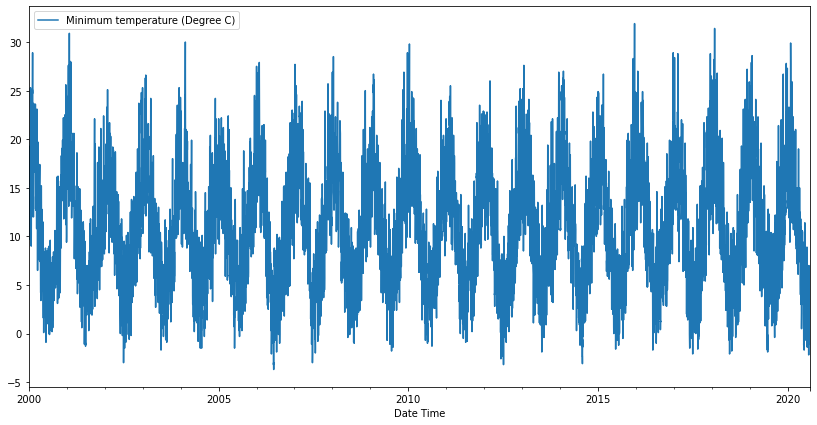

In [101]:
midulrashire_mintemp.plot(figsize=(14,7))

### Train test split

In [82]:
def train_test_split(data_set,name,ratio):
    print(name+' total samples: ',len(data_set))
    split_row = int(len(data_set)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',len(data_set)-split_row)
    train_set = data_sest.iloc[:split_row]
    test_set = data_set.iloc[split_row:]
    return train, test, split_row 
    

### Data Transformation

We need to scale the the data so it will reduce the computional cost of the training step

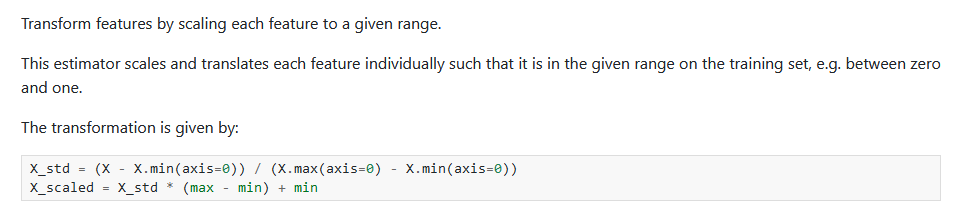
We will use Minmax Scaler from sklearn library

In [96]:
def data_transformation(train_data,testing_data):
    my_scaler=MinMaxScaler()
    train_data_scaled = my_scaler.fit_transform(train_data)
    test_data_scaled = my_scaler.fit_transform(testing_data)
    scaled_train_data_df = pd.DataFrame(train_data_scaled, index = train_data.index, columns=[train_data.columns[0]])
    test_data_scaled_df = pd.DataFrame(test_data_scaled, index = train_data.index, columns=[testing_data.columns[0]])
    
    return data_scaled_df,my_scaler

Create lagged values for the time series data

In [85]:
def add_lagged_value(df,lag):
    data_cp = df.copy()
    for i in range (1,lag):
        data_cp['lag' + str(i)] = df.shift(i)
    return data_cp

In [ ]:
def extract_x_y(data):
    return data.columns[0].values

## Define LSTM model

LSTM model includes 3 stacked LSTM layer with the output layer is dense layer. We will use drop out (20%) to prevent the gradient vanishing problem and Adam for gradient optimization

In [27]:
def lstm(units, x_train,y_train,x_test,y_test,EPOCHS=100,size_batch=120):
    model = Sequential()
    mode.add(Bidirectional(LSTM(units,return_sequence = True,input_shape=(x_train.shape[0],x_train.shape[1]))))
    model.add(Dropout(0.2))
    model.add(LSTM(units,return_sequence=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.001),loss='mean_squared_error',metric=['acc'])

    model.fit(x_train,y_train,batch_size=size_batch,epochs=EPOCHS, validation_data=(x_test,y_test),verbose=0)
    return model

### Validation test

In [28]:
def validation_test(model,x_test,y_test,scaler,split_row,lag):
    y_predict= model.predict(x_test)
    score = r2_score(y_test,y_predict)
    print('Test R-squared is: ' + str(score))
    # we need to inverse value (0-1) to the normal temperature C value
    y_predict= scaler.inverse_transform(y_predict)
    result=x_test.copy()
    result['true_y']=y_test
    result['forecast']=y_predict
    return result

## Min Temperature Predicting Model

In [ ]:
def min_temp_lstm(data_from_station,lag):
    train_data,test_data,split_row=train_test_split(data_from_station,"Mildura Shire",0.7)
    train_data_scaled,test_data_scaled,my_scaler = data_transformation(train_data,test_data)